## Read time series data and split

In [1]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
#jax.config.update("jax_disable_jit", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import pickle

In [2]:
# Read
df = pd.read_parquet("dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
#df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize
* Delta tokens by derivation
* Global discretization

Current setup:
* delta tokens
* n_bins = 1024
* fixed size bins

Future:
* discretize each column individually
* quantile-based bins (centered at 0)

In [3]:
# Z-norm standardisation
#X['Power demand'] = np.log1p(X['Power demand'])
mu = X.mean(axis=0)
sigma = X.std(axis=0) + 1e-8

X_normalized = (X-mu)/sigma
X_normalized = X_normalized.diff().dropna()
X_nv = X_normalized.values.astype(np.float32)   # (N, D)

In [4]:
# fit bins
n_bins=1024

#edges, mids = discretize.fit_quantile_bins_global(X_nv, n_bins=n_bins)
edges, mids = discretize.fit_equal_width_bins_global(X_nv, n_bins=n_bins)

# encode
#X_tok = discretize.encode_quantile_global(jnp.asarray(X_nv), edges)
X_tok = discretize.encode_equal_width_global(jnp.asarray(X_nv), edges)

# decode
#X_rec = discretize.decode_quantile_global(X_tok, mids)
X_rec = discretize.decode_equal_width_global(X_tok, mids)

ZERO_BIN = int(np.argmin(np.abs(mids)))
#or
assert(ZERO_BIN == discretize.encode_equal_width_global(jnp.asarray([0]), edges))

print("Zero midpoint:", mids[ZERO_BIN])
print("Index:", ZERO_BIN)


W1222 08:11:25.653513  174860 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1222 08:11:25.657181  169601 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Zero midpoint: -0.0015580654
Index: 514


In [5]:
X_normalized

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
1,-0.137114,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,-0.112688,-0.061602,-0.089990,-0.041230,0.000000,0.00000,0.152233
3,-0.047263,-0.061602,0.006922,0.144305,0.000000,0.00000,0.000000
4,0.055827,-0.061602,0.027689,0.185536,0.000000,0.00000,-0.152233
5,0.251982,-0.147844,-0.256124,-0.185536,0.000000,0.00000,0.173980
...,...,...,...,...,...,...,...
27663,-0.089561,-0.061602,-0.207668,-0.082460,0.045609,-0.16581,-0.072492
27664,-0.018132,-0.012320,-0.283813,-0.164921,0.000000,-0.16581,-0.065243
27665,0.114572,-0.061602,0.083067,0.082460,-0.045609,0.00000,-0.014498
27666,0.146685,-0.123203,0.089990,0.123690,-0.136826,-0.33162,0.000000


In [6]:
pd.DataFrame(X_tok)

,0,1,2,3,4,5,6
0,500,514,514,514,514,514,514
1,503,508,505,510,514,514,530
2,509,508,515,529,514,514,514
3,520,508,517,533,514,514,498
4,540,499,488,495,514,514,532
...,...,...,...,...,...,...,...
27662,505,508,493,506,519,497,507
27663,512,513,485,497,514,497,507
27664,526,508,523,523,509,514,513
27665,529,501,523,527,500,480,514


In [7]:
pd.DataFrame(X_rec)

,0,1,2,3,4,5,6
0,-0.137272,-0.001558,-0.001558,-0.001558,-0.001558,-0.001558,-0.001558
1,-0.108190,-0.059721,-0.088803,-0.040333,-0.001558,-0.001558,0.153543
2,-0.050027,-0.059721,0.008136,0.143850,-0.001558,-0.001558,-0.001558
3,0.056605,-0.059721,0.027524,0.182625,-0.001558,-0.001558,-0.156659
4,0.250482,-0.146966,-0.253598,-0.185741,-0.001558,-0.001558,0.172931
...,...,...,...,...,...,...,...
27662,-0.088803,-0.059721,-0.205129,-0.079109,0.046911,-0.166353,-0.069415
27663,-0.020946,-0.011252,-0.282679,-0.166353,-0.001558,-0.166353,-0.069415
27664,0.114768,-0.059721,0.085686,0.085686,-0.050027,-0.001558,-0.011252
27665,0.143850,-0.127578,0.085686,0.124462,-0.137272,-0.331148,-0.001558


## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

In [8]:
n_channels = len(X.columns)
#tokens = tokenizer.encode_with_channels(X_tok, n_channels)
tokens = tokenizer.encode_with_channels_sparse(X_tok, n_channels, ZERO_BIN)

DATA_OFFSET = 2 + n_channels  # BOS+EOS+n_channels = 9
vocab_size = DATA_OFFSET + n_bins

In [9]:
#ROW_LEN = 2 + 2 * n_channels

T = tokens.shape[0]
print("Total tokens:", T)
print("Vocab size:", vocab_size)
#print("ROW_LEN:", ROW_LEN)
#print("Remainder:", T % ROW_LEN)

# Inspect first few tokens
print("First 100 tokens:", tokens[:100])
#print("First 3 rows reshaped (raw):")
#print(tokens[:3 * ROW_LEN].reshape(3, ROW_LEN))

Total tokens: 373770
Vocab size: 1033
First 100 tokens: [  0   2 509   1   0   2 512   3 517   4 514   5 519   8 539   1   0   2
 518   3 517   4 524   5 538   1   0   2 529   3 517   4 526   5 542   8
 507   1   0   2 549   3 508   4 497   5 504   8 541   1   0   2 578   3
 517   4 509   5 508   8 531   1   0   2 596   3 526   4 528   5 527   8
 520   1   0   2 580   3 524   4 525   5 525   8 550   1   0   2 558   3
 536   4 530   5 510   8 531   1   0   2]


# Training

In [10]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd
import math

from helper_funcs import generate, masked_fill
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CudaDevice(id=0)]


In [11]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization

rng_key = jax.random.PRNGKey(42)

In [12]:
rng_key, subkey = jax.random.split(rng_key)
xb, yb = tokenizer.get_token_batch(tokens, subkey, batch_size, n_channels, block_size)
token_types = tokenizer.compute_token_types(xb, n_channels)

## Build the Attention Model

In [13]:
from attention_model import *
model = GPT2_v3(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate, n_channels)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
dummy_token_types = jnp.zeros_like(dummy_x)
dummy_channel_ids = jnp.zeros_like(dummy_x)
variables = model.init(rng_key, dummy_x, dummy_token_types, dummy_channel_ids)

In [14]:
out = model.apply(variables, dummy_x, dummy_token_types, dummy_channel_ids)
print(out.shape)

(4, 480, 1033)


## Time Series Generation Pre-Training

In [16]:
#index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
#max_new_tokens = 240
learning_rate=1e-5

#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#decode(generated_indices, X)

## Train the Model

In [17]:
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate)
)
opt_state = optimizer.init(variables)
losses = []

**Cross-entropy intuition**

For a model that is basically guessing, the expected loss is:

$$loss≈log⁡(vocab size)$$

More epochs will just produce more samples of the same noise band.

In [18]:
np.log(vocab_size)

np.float64(6.940222469119639)

In [ ]:
epochs = 500000
train_tokens = tokens

pbar = tqdm(range(epochs))
for epoch in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = tokenizer.get_token_batch(train_tokens, subkey, batch_size, n_channels, block_size)
    token_types = tokenizer.compute_token_types(xb, n_channels)
    channel_ids = tokenizer.compute_channel_ids(xb, n_channels)

    loss, grads = value_and_grad(tokenizer.loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        token_types,
        channel_ids,
        n_channels,
        yb
    )

    if math.isnan(loss):
        print(f"Premature stop (loss=nan) at epoch {epoch}")
        break

    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    losses.append(loss)
    
    pbar.set_description(f"Epoch: {epoch}, Loss: {loss :.4f}")

In [ ]:
# Save model
model_file = {
    "epochs": epochs,
    "epoch": epoch,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
    "n_channels": n_channels,
    "n_bins": n_bins,
    "edges": edges, 
    "mids": mids,
    "mu": mu,
    "sigma": sigma,
}

with open('models/token_model.pkl', 'wb') as f:
    pickle.dump(model_file, f)

In [14]:
# Load model
with open('models/token_model.pkl', 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)

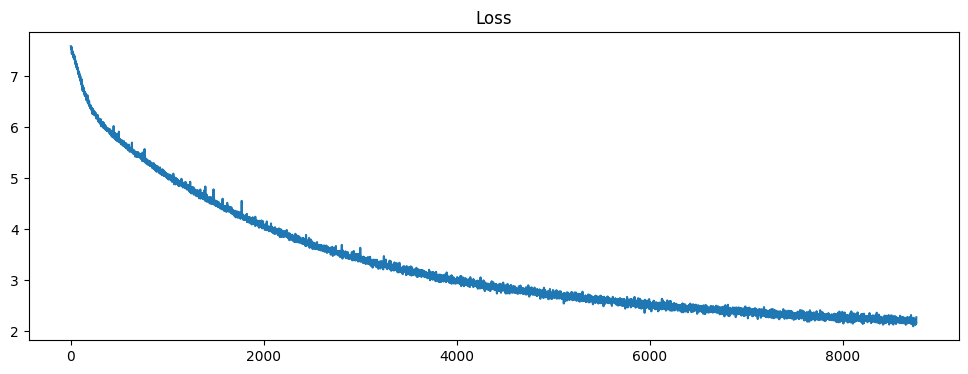

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [16]:
rng_key = jax.random.PRNGKey(128)

In [17]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import lax

def infer_token_types_and_channels(tokens, n_channels):
    """
    tokens: (B, T)
    returns:
        token_types: (B, T)
        channel_ids: (B, T)
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    # token type ids
    token_types = jnp.where(
        tokens == BOS, 0,
        jnp.where(
            tokens == EOS, 1,
            jnp.where(
                tokens < DATA_OFFSET, 2,  # CH
                3                           # DATA
            )
        )
    )

    # channel ids
    channel_ids = jnp.where(
        (tokens >= CH_OFFSET) & (tokens < DATA_OFFSET),
        tokens - CH_OFFSET,
        0
    )

    return token_types, channel_ids

def token_type(tok, n_channels):
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    return jnp.where(
        tok == BOS, 0,
        jnp.where(
            tok == EOS, 1,
            jnp.where(
                tok < DATA_OFFSET, 2,  # CH
                3                       # DATA
            )
        )
    )

def grammar_mask(last_tok, n_channels, vocab_size):
    """
    Returns mask: True = allowed, False = forbidden
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    ttype = token_type(last_tok, n_channels)

    allowed = jnp.zeros((vocab_size,), dtype=jnp.bool_)

    def allow(mask, lo, hi):
        return mask.at[lo:hi].set(True)

    # BOS → CH or EOS
    allowed = jax.lax.cond(
        ttype == 0,
        lambda m: allow(allow(m, CH_OFFSET, DATA_OFFSET), EOS, EOS + 1),
        lambda m: m,
        allowed
    )

    # CH → DATA
    allowed = jax.lax.cond(
        ttype == 2,
        lambda m: allow(m, DATA_OFFSET, vocab_size),
        lambda m: m,
        allowed
    )

    # DATA → CH or EOS
    allowed = jax.lax.cond(
        ttype == 3,
        lambda m: allow(allow(m, CH_OFFSET, DATA_OFFSET), EOS, EOS + 1),
        lambda m: m,
        allowed
    )

    # EOS → EOS only
    allowed = jax.lax.cond(
        ttype == 1,
        lambda m: m.at[EOS].set(True),
        lambda m: m,
        allowed
    )

    return allowed

@partial(
    jax.jit,
    static_argnames=[
        'forward_fn',
        'vocab_size',
        'block_size',
        'max_new_tokens',
        'n_channels',
    ],
)
def generate_sparse(
    variables,
    forward_fn,
    index_seq,     # (T,)
    rng_key,
    vocab_size,
    block_size,
    max_new_tokens,
    n_channels,
    EOS=1,
):
    # -----------------------------
    # constants
    # -----------------------------
    BOS = 0
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    index_seq = jnp.asarray(index_seq)
    T = index_seq.shape[0]
    B = 1

    total_len = block_size + T + max_new_tokens

    # output buffer
    out = jnp.zeros((B, total_len), dtype=index_seq.dtype)

    # write initial tokens after padding
    out = lax.dynamic_update_slice(
        out,
        index_seq[None, :],
        (0, block_size),
    )

    write_pos = block_size + T

    finished = jnp.zeros((B,), dtype=jnp.bool_)
    emitted_any = jnp.zeros((B,), dtype=jnp.bool_)

    # -----------------------------
    # scan step
    # -----------------------------
    def step(carry, _):
        out, rng, write_pos, finished, emitted_any = carry

        # ---- context window ----
        start = jnp.maximum(write_pos - block_size, 0)
        ctx = lax.dynamic_slice(out, (0, start), (B, block_size))

        token_types, channel_ids = infer_token_types_and_channels(
            ctx, n_channels
        )

        logits = forward_fn(
            variables,
            ctx,
            token_types,
            channel_ids,
        )
        logits = logits[:, -1]  # (B, vocab)

        last_tok = ctx[:, -1]   # (B,)

        # -----------------------------
        # grammar mask (CORRECT)
        # -----------------------------
        mask = jnp.zeros((vocab_size,), dtype=jnp.bool_)

        is_bos = last_tok[0] == BOS
        is_ch  = (last_tok[0] >= CH_OFFSET) & (last_tok[0] < DATA_OFFSET)
        is_data = last_tok[0] >= DATA_OFFSET

        def bos_case(m):
            return m.at[CH_OFFSET:DATA_OFFSET].set(True)

        def ch_case(m):
            return m.at[DATA_OFFSET:].set(True)

        def data_case(m):
            m = m.at[CH_OFFSET:DATA_OFFSET].set(True)
            m = m.at[EOS].set(emitted_any[0])
            return m

        mask = jax.lax.cond(
            is_bos,
            bos_case,
            lambda m: jax.lax.cond(
                is_ch,
                ch_case,
                data_case,
                m
            ),
            mask
        )

        # -----------------------------
        # sampling
        # -----------------------------
        rng, sub = jax.random.split(rng)

        temperature = 1.0
        masked_logits = jnp.where(mask, logits / temperature, -1e9)

        next_tok = jax.random.categorical(sub, masked_logits)

        # force EOS if already finished
        next_tok = jnp.where(finished, EOS, next_tok)

        # -----------------------------
        # update state
        # -----------------------------
        out = lax.dynamic_update_slice(
            out,
            next_tok[:, None],
            (0, write_pos),
        )

        is_data_tok = next_tok >= DATA_OFFSET
        emitted_any = emitted_any | is_data_tok

        # reset emitted_any on BOS (row boundary)
        emitted_any = jax.lax.select(
            next_tok == BOS,
            jnp.zeros_like(emitted_any),
            emitted_any,
        )

        finished = jnp.logical_or(finished, next_tok == EOS)
        write_pos = write_pos + 1

        return (out, rng, write_pos, finished, emitted_any), None

    # -----------------------------
    # run scan
    # -----------------------------
    (out, _, write_pos, _, _), _ = lax.scan(
        step,
        (out, rng_key, write_pos, finished, emitted_any),
        None,
        length=max_new_tokens,
    )

    # return flat buffer and write position
    return out[0], write_pos

In [18]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_equal_width_global(jnp.asarray(X_test_nv), edges)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, ZERO_BIN)
token_stream = test_tokens[-block_size:] #.reshape(1,-1) # B, T

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Context window:", block_size)
print("Last context tokens:", token_stream)

Number of tokens: 6810
Context window: 480
Last context tokens: [521   4 551   5 542   6 533   7 438   8 499   1   0   2 477   3 517   4
 513   5 521   6 533   7 506   1   0   2 509   3 519   4 500   5 510   6
 499   7 468   8 547   1   0   2 545   3 512   4 562   5 557   6 391   7
 485   8 516   1   0   1   0   1   0   1   0   2 477   3 475   4 589   5
 625   6 595   7 561   8 522   1   0   2 499   3 532   4 521   5 510   6
 537   7 502   8 524   1   0   2 504   3 503   4 519   5 542   6 490   8
 513   1   0   2 508   3 504   4 515   5 536   6 533   7 561   1   0   2
 509   3 524   4 513   5 510   6 547   7 561   8 533   1   0   2 513   3
 516   4 515   6 533   7 540   8 522   1   0   2 521   3 517   4 495   5
 500   6 528   7 609   8 531   1   0   2 528   3 531   4 510   5 500   6
 518   7 629   8 540   1   0   2 529   3 546   4 560   5 536   6 528   7
 560   8 526   1   0   2 556   3 549   4 531   5 506   6 528   7 486   8
 531   1   0   2 559   3 545   4 502   5 485   6 533   7 486

In [23]:
# TODO Autoregressive rollout:
# Feed in test_tokens context window (same context +1 out)
# Generate one new token, add to context, dismiss first token in context. The model should now adhere to grammar.
# When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], add it to new_rows.
# Convert the new row into delta values and add to dataframe 
# (here we could do sim: change this row, convert back to tokens, sparse encoding, replace that frame in context for new feed)
# Stop when we have stepped block_size (context window size)
# We should now have a dataframe of new deltas
# TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

#xb, yb = tokenizer.get_token_batch(test_tokens, subkey, batch_size, n_channels, block_size)

# Rollout step
#token_types = tokenizer.compute_token_types(token_stream, n_channels)
#channel_ids = tokenizer.compute_channel_ids(token_stream, n_channels)
#logits = model.apply(variables, token_stream, token_types, channel_ids)

def token_type(tok, n_channels):
    BOS = 0
    EOS = 1
    DATA_OFFSET = 2 + n_channels

    return jnp.where(
        tok == BOS, 0,
        jnp.where(
            tok == EOS, 1,
            jnp.where(tok < DATA_OFFSET, 2, 3)
        )
    )

def grammar_mask_from_last(
    last_tok,
    emitted_any,
    vocab_size,
    n_channels,
):
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    ttype = token_type(last_tok, n_channels)
    mask = jnp.zeros((vocab_size,), dtype=jnp.bool_)

    def bos_case(m):
        return m.at[CH_OFFSET:DATA_OFFSET].set(True)

    def ch_case(m):
        return m.at[DATA_OFFSET:].set(True)

    def data_case(m):
        m = m.at[CH_OFFSET:DATA_OFFSET].set(True)
        m = m.at[EOS].set(emitted_any)
        return m

    def eos_case(m):
        return m.at[BOS].set(True)

    return lax.switch(
        ttype,
        [bos_case, eos_case, ch_case, data_case],
        mask,
    )

#Non-JIT
#def emitted_any_from_stream(stream, n_channels):
#    DATA_OFFSET = 2 + n_channels
#    BOS = 0

#    # find last BOS
#    is_bos = stream == BOS
#    idx = jnp.where(is_bos, jnp.arange(stream.shape[0]), -1)
#    last_bos = jnp.max(idx)

#    tail = stream[last_bos + 1 :]
#    return jnp.any(tail >= DATA_OFFSET)

def emitted_any_from_stream(stream, n_channels):
    BOS = 0
    DATA_OFFSET = 2 + n_channels

    T = stream.shape[0]
    idx = jnp.arange(T)

    # index of last BOS
    is_bos = stream == BOS
    last_bos = jnp.max(jnp.where(is_bos, idx, -1))

    # DATA tokens strictly after last BOS
    is_data_after = (stream >= DATA_OFFSET) & (idx > last_bos)

    return jnp.any(is_data_after)

@partial(
    jax.jit,
    static_argnames=[
        'forward_fn',
        'vocab_size',
        'block_size',
        'max_new_tokens',
        'n_channels',
    ],
)
def generate_continue(
    variables,
    forward_fn,
    token_stream,     # (T,)
    rng_key,
    vocab_size,
    block_size,
    max_new_tokens,
    n_channels,
    BOS = 0,
    EOS=1,
):
    token_stream = jnp.asarray(token_stream)

    # infer emitted_any from history
    DATA_OFFSET = 2 + n_channels
    #emitted_any = jnp.any(token_stream >= DATA_OFFSET)
    emitted_any = emitted_any_from_stream(token_stream, n_channels)

    def step(carry, _):
        #stream, rng, emitted_any = carry
        ctx, rng, emitted_any = carry

        #ctx = stream[-block_size:] replaced with JIT-friendly next three lines:
        #T = stream.shape[0]
        #start = jnp.maximum(T - block_size, 0)
        #ctx = lax.dynamic_slice(stream, (start,), (block_size,))

        # was ctx
        ctx_batched = ctx[None, :]  # (1, T)

        token_types, channel_ids = infer_token_types_and_channels(
            ctx_batched, n_channels # was ctx
        )

        logits = forward_fn(
            variables,
            ctx_batched, #ctx,
            token_types,
            channel_ids,
        )[:, -1]  # (1, vocab)

        last_tok = ctx[-1] #ctx[0, -1]

        mask = grammar_mask_from_last(
            last_tok,
            emitted_any,
            vocab_size,
            n_channels,
        )

        rng, sub = jax.random.split(rng)
        masked_logits = jnp.where(mask, logits, -1e9)
        next_tok = jax.random.categorical(sub, masked_logits)[0]

        # update emitted_any
        is_data = next_tok >= DATA_OFFSET
        emitted_any = lax.select(
            next_tok == BOS, 
            False, 
            emitted_any | is_data
        )

        # roll context left and append next token
        ctx = jnp.concatenate([ctx[1:], jnp.array([next_tok])], axis=0)
        return (ctx, rng, emitted_any), next_tok

        #stream = jnp.concatenate([stream, jnp.array([next_tok])], axis=0)
        #return (stream, rng, emitted_any), next_tok

    # pad on the left if token_stream is shorter than block_size
    pad = jnp.zeros((max(0, block_size - token_stream.shape[0]),), dtype=token_stream.dtype)
    ctx0 = jnp.concatenate([pad, token_stream[-block_size:]], axis=0)

    (_, _, _), new_tokens = lax.scan(
        step,
        #(token_stream, rng_key, emitted_any),
        (ctx0, rng_key, emitted_any),
        None,
        length=max_new_tokens,
    )

    return new_tokens

rng_key, subkey = jax.random.split(rng_key)

new_tokens = generate_continue(
    variables,
    model.apply,
    token_stream=token_stream,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

#buf, write_pos = generate_sparse(
#    variables,
#    model.apply,
#    token_stream,   # must end in EOS
#    rng_key,
#    vocab_size=vocab_size,
#    block_size=block_size,
#    max_new_tokens=16,
#    n_channels=n_channels
#)
#generated = buf[block_size:write_pos]

In [24]:
new_tokens

Array([  0,   3, 480,   3, 502,   3, 511,   3, 388,   3, 533,   4, 544,
         8, 870,   3, 509,   4, 526,   8, 549,   3, 538,   3, 517,   8,
       525,   2, 566,   6, 506,   2, 533,   3, 516,   3, 532,   3, 505,
         6, 487,   3, 519,   5, 504,   4, 506,   3, 520,   6, 530,   3,
       540,   4, 526,   3, 531,   3, 554,   3, 528,   3, 521,   3, 121,
         5, 519,   5, 519,   8, 536,   1,   0,   5, 508,   3, 481,   6,
       518,   8, 712,   3, 507,   3, 528,   8, 518,   3, 506,   1,   0,
         2, 512,   3, 978,   3, 502,   3, 534,   2, 546,   8, 132,   3,
       531,   8, 688,   1,   0,   8, 492,   3, 528,   3, 532,   3, 401,
         2, 538,   1,   0,   8, 530,   3, 681,   3, 521,   3, 513,   3,
       531,   3, 232,   5, 514,   1,   0,   4, 522,   3, 496,   4, 528,
         3, 517,   3, 555,   8,  24,   3, 811,   4, 555,   3, 531,   4,
       508,   3, 508,   3, 516,   8, 498,   8, 515,   1,   0,   8, 528,
         1,   0,   3, 779,   1,   0,   8, 517,   3, 574,   3, 53

In [25]:
import jax.numpy as jnp

def decode_with_channels_stream(flat, n_channels):
    """
    Decode a flat token stream into completed frames.

    Rules:
    - Frames start at BOS (0)
    - Frames end at EOS (1)
    - CH tokens select channel
    - DATA tokens assign value to last CH
    - Unfinished trailing frames are skipped

    Returns:
        (N, n_channels) array
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    flat = jnp.asarray(flat)

    rows = []
    i = 0
    L = flat.shape[0]

    while i < L:
        # wait for BOS
        if flat[i] != BOS:
            i += 1
            continue

        i += 1  # consume BOS
        row = jnp.zeros((n_channels,), dtype=flat.dtype)
        seen = jnp.zeros((n_channels,), dtype=bool)
        current_ch = -1

        while i < L and flat[i] != EOS:
            tok = flat[i]

            # channel token
            if CH_OFFSET <= tok < DATA_OFFSET:
                current_ch = tok - CH_OFFSET

            # data token
            elif tok >= DATA_OFFSET and current_ch >= 0:
                row = row.at[current_ch].set(tok - DATA_OFFSET)
                seen = seen.at[current_ch].set(True)

            i += 1

        # emit only if EOS found and at least one channel seen
        if i < L and flat[i] == EOS and jnp.any(seen):
            rows.append(row)

        i += 1  # consume EOS

    if len(rows) == 0:
        return jnp.empty((0, n_channels), dtype=flat.dtype)

    return jnp.stack(rows, axis=0)

In [26]:
new_tokens

Array([  0,   3, 480,   3, 502,   3, 511,   3, 388,   3, 533,   4, 544,
         8, 870,   3, 509,   4, 526,   8, 549,   3, 538,   3, 517,   8,
       525,   2, 566,   6, 506,   2, 533,   3, 516,   3, 532,   3, 505,
         6, 487,   3, 519,   5, 504,   4, 506,   3, 520,   6, 530,   3,
       540,   4, 526,   3, 531,   3, 554,   3, 528,   3, 521,   3, 121,
         5, 519,   5, 519,   8, 536,   1,   0,   5, 508,   3, 481,   6,
       518,   8, 712,   3, 507,   3, 528,   8, 518,   3, 506,   1,   0,
         2, 512,   3, 978,   3, 502,   3, 534,   2, 546,   8, 132,   3,
       531,   8, 688,   1,   0,   8, 492,   3, 528,   3, 532,   3, 401,
         2, 538,   1,   0,   8, 530,   3, 681,   3, 521,   3, 513,   3,
       531,   3, 232,   5, 514,   1,   0,   4, 522,   3, 496,   4, 528,
         3, 517,   3, 555,   8,  24,   3, 811,   4, 555,   3, 531,   4,
       508,   3, 508,   3, 516,   8, 498,   8, 515,   1,   0,   8, 528,
         1,   0,   3, 779,   1,   0,   8, 517,   3, 574,   3, 53

In [27]:
new_Y_tok = decode_with_channels_stream(new_tokens, n_channels)
new_Y_tok

Array([[524, 112, 517, 510, 521,   0, 527],
       [  0, 497,   0, 499, 509,   0, 509],
       [537, 522,   0,   0,   0,   0, 679],
       [529, 392,   0,   0,   0,   0, 483],
       [  0, 223,   0, 505,   0,   0, 521],
       [  0, 507, 499,   0,   0,   0, 506],
       [  0,   0,   0,   0,   0,   0, 519],
       [  0, 770,   0,   0,   0,   0,   0],
       [  0, 521,   0, 550,   0,   0, 508],
       [528, 508,   0,   0, 503, 520, 500],
       [522, 495, 319,   0,   0,   0, 569],
       [491, 501,   0,   0,   0,   0, 521],
       [495, 672, 532, 490,   0,   0,  45],
       [497, 533, 496, 922,   0,   0, 515],
       [  0, 557, 513,   0,   0,   0, 499],
       [510,   0,   0,   0,   0,   0,   0],
       [516, 500,   0, 563,   0,   0, 521],
       [  0, 533, 914,   0, 802,   0,   0],
       [500, 501, 502,   0, 494,   0, 519],
       [517, 513,   0,   0,   0,   0, 710],
       [537, 511,   0, 247,   0,   0,   0]], dtype=int32)

In [28]:
# Replace 0 with MID_POINT (no change)
#new_Y_tok = jnp.where(new_Y_tok == 0, ZERO_BIN, new_Y_tok)
new_Y_tok

Array([[524, 112, 517, 510, 521,   0, 527],
       [  0, 497,   0, 499, 509,   0, 509],
       [537, 522,   0,   0,   0,   0, 679],
       [529, 392,   0,   0,   0,   0, 483],
       [  0, 223,   0, 505,   0,   0, 521],
       [  0, 507, 499,   0,   0,   0, 506],
       [  0,   0,   0,   0,   0,   0, 519],
       [  0, 770,   0,   0,   0,   0,   0],
       [  0, 521,   0, 550,   0,   0, 508],
       [528, 508,   0,   0, 503, 520, 500],
       [522, 495, 319,   0,   0,   0, 569],
       [491, 501,   0,   0,   0,   0, 521],
       [495, 672, 532, 490,   0,   0,  45],
       [497, 533, 496, 922,   0,   0, 515],
       [  0, 557, 513,   0,   0,   0, 499],
       [510,   0,   0,   0,   0,   0,   0],
       [516, 500,   0, 563,   0,   0, 521],
       [  0, 533, 914,   0, 802,   0,   0],
       [500, 501, 502,   0, 494,   0, 519],
       [517, 513,   0,   0,   0,   0, 710],
       [537, 511,   0, 247,   0,   0,   0]], dtype=int32)

In [29]:
import jax.numpy as jnp

def decode_equal_width_global(tokens, mids):
    """
    Global equal-width decoding.

    tokens: (T, D)
    mids:   (n_bins,)
    returns: (T, D) approx continuous values
    """
    mids = jnp.asarray(mids)
    tokens = jnp.asarray(tokens)

    tokens_clipped = jnp.clip(tokens, 0, mids.shape[0] - 1)
    values = mids[tokens_clipped]

    return jnp.where(tokens == 0, 0.0, values) # jnp.nan

Delta model, so mu is not added back

$$
\frac{(x_t - \mu) - (x_{t-1} - \mu)}{\sigma}
\quad\equiv\quad
\frac{x_t - x_{t-1}}{\sigma}
$$

In [30]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_rec = decode_equal_width_global(new_Y_tok, mids)
Y_rec = pd.DataFrame(Y_rec, columns=X.columns)
Y_rec = Y_rec * sigma # delta model so mu is not added back

init_values = X_test.iloc[-1].values
Y_pred = init_values + jnp.cumsum(Y_rec.values, axis=0)

Y_pred = pd.DataFrame(Y_pred, columns=X.columns)
Y_pred

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,4971.854004,4.357349,18.748804,35.021751,277.268250,13.000000,1000.358459
1,4971.854004,3.007118,18.748804,31.457235,271.783844,13.000000,1000.013428
2,5246.277344,3.623928,18.748804,31.457235,271.783844,13.000000,1011.034851
3,5424.577637,-5.987873,18.748804,31.457235,271.783844,13.000000,1008.951355
4,5424.577637,-28.896866,18.748804,29.303408,271.783844,13.000000,1009.408691
5,5424.577637,-29.460281,17.687262,29.303408,271.783844,13.000000,1008.863037
6,5424.577637,-29.460281,17.687262,29.303408,271.783844,13.000000,1009.186584
7,5424.577637,-9.330437,17.687262,29.303408,271.783844,13.000000,1009.186584
8,5424.577637,-8.792309,17.687262,37.729774,271.783844,13.000000,1008.774658
9,5590.862793,-9.277042,17.687262,37.729774,259.923126,13.307247,1007.827881


In [31]:
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_rec)].reset_index(drop=True)
Y_test

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,4909.759167,38.00,22.50,41.5,270.0,16.60,998.15
1,5009.161667,39.50,24.05,42.0,285.0,16.60,998.15
2,4972.035833,40.50,22.05,35.0,305.0,13.00,998.50
3,5216.492500,41.10,24.80,40.5,315.0,12.10,996.80
4,5291.605000,41.10,24.80,40.5,320.0,11.20,996.30
5,5237.464167,41.00,22.00,34.0,305.0,8.50,996.50
6,5115.057500,40.60,24.00,39.5,280.0,7.60,994.85
7,4984.437500,40.10,24.50,41.5,265.0,6.50,994.85
8,5072.750000,39.50,23.00,39.0,245.0,5.40,996.00
9,5063.483333,37.40,22.35,42.0,240.0,5.40,995.45


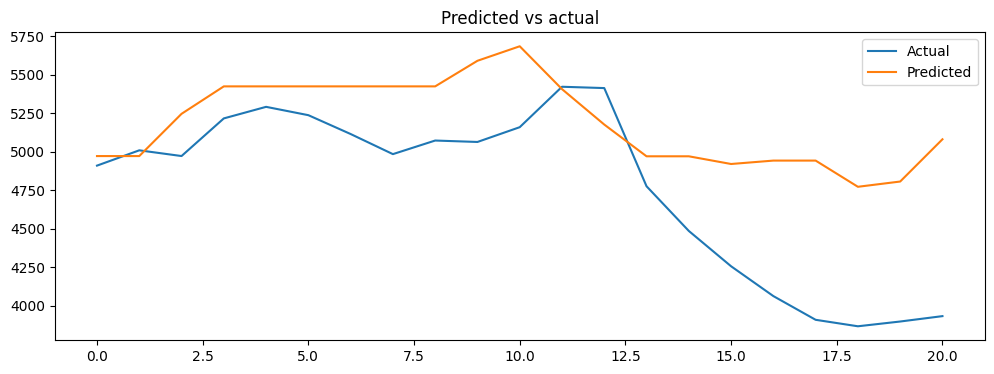

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.plot(Y_pred.index, Y_pred['Power demand'], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()

# Nothing interesting down here

In [ ]:
def decode_sparse_row(tokens, n_channels, zero_bin, mids):
    """
    tokens: (L,) sparse token row (BOS ... EOS)
    returns: (D,) delta vector
    """
    D = n_channels
    delta = jnp.full((D,), mids[zero_bin])

    i = 0
    while i < len(tokens):
        tok = tokens[i]

        if tok == 0 or tok == 1:  # BOS / EOS
            i += 1
            continue

        ch = tok - 2
        data = tokens[i + 1] - (2 + n_channels)

        delta = delta.at[ch].set(mids[data])
        i += 2

    return delta

def encode_dense_row_to_sparse(
    x_row,           # (D,)
    prev_x_row,      # (D,)
    edges,
    zero_bin,
    n_channels,
):
    """
    Dense → delta → discretize → sparse tokens
    """
    # delta
    delta = x_row - prev_x_row

    # discretize (global)
    delta_bins = discretize.encode_equal_width_global(
        delta[None, :], edges
    )[0]

    # sparse tokenize
    tokens = tokenizer.encode_with_channels_sparse(
        delta_bins[None, :],
        n_channels,
        zero_bin,
    )

    return tokens

def trim_at_eos(tokens, EOS=1):
    idx = jnp.argmax(tokens == EOS)
    return tokens[:idx + 1]

def extract_last_row(token_stream, write_pos, BOS=0, EOS=1):
    stream = token_stream[:write_pos]

    eos_idx = jnp.max(
        jnp.where(stream == EOS, size=stream.shape[0], fill_value=-1)[0]
    )

    bos_idx = jnp.max(
        jnp.where(stream[:eos_idx] == BOS, size=stream.shape[0], fill_value=-1)[0]
    )

    return stream[bos_idx : eos_idx + 1]
    
def rollout_one_step(
    variables,
    model,
    rng_key,
    token_stream,    # NEW
    write_pos,       # NEW
    last_x,          # (D,)
    prev_x,          # (D,)
    edges,
    mids,
    zero_bin,
    n_channels,
    block_size,
    max_new_tokens,
):
    # encode conditioning row
    #cond_tokens = encode_dense_row_to_sparse(
    #    last_x,
    #    prev_x,
    #    edges,
    #    zero_bin,
    #    n_channels,
    #)
    #print(token_stream[:write_pos])

    # generate next sparse row
    buf, write_pos = generate_sparse(
        variables,
        model.apply,
        token_stream[:write_pos], #cond_tokens,
        rng_key,
        vocab_size=vocab_size,
        block_size=block_size,
        max_new_tokens=max_new_tokens,
        n_channels=n_channels,
    )
    
    token_stream = buf[:write_pos]

    #gen_tokens = buf[block_size:write_pos]
    gen_tokens = extract_last_row(token_stream, write_pos)
    gen_tokens = trim_at_eos(gen_tokens)
    #print(gen_tokens)
    
    # decode to delta
    delta_hat = decode_sparse_row(
        gen_tokens,
        n_channels,
        zero_bin,
        mids,
    )

    # apply delta
    next_x = last_x + delta_hat

    #return next_x, gen_tokens
    return next_x, token_stream, write_pos

def autoregressive_rollout(
    variables,
    model,
    rng_key,
    X_init,          # (T0, D)
    steps,
    edges,
    mids,
    zero_bin,
    n_channels,
    block_size,
    max_new_tokens,
):
    X = [X_init[-1]]
    prev = X_init[-2]

    tokens_out = []

    #token_stream = encode_dense_row_to_sparse(
    #    X_init[-1],
    #    X_init[-2],
    #   edges,
    #    zero_bin,
    #    n_channels,
    #)
    #write_pos = token_stream.shape[0]
    token_rows = []

    for t in range(1, X_init.shape[0]):
        row_tokens = encode_dense_row_to_sparse(
            X_init[t],
            X_init[t - 1],
            edges,
            zero_bin,
            n_channels,
        )
        print(row_tokens)
        token_rows.append(row_tokens)

    token_stream = jnp.concatenate(token_rows)
    write_pos = token_stream.shape[0]

    for _ in tqdm(range(steps)):
        rng_key, sub = jax.random.split(rng_key)

        #next_x, gen_tokens = rollout_one_step(
        next_x, token_stream, write_pos = rollout_one_step(
            variables,
            model,
            sub,
            token_stream,
            write_pos,
            X[-1],
            prev,
            edges,
            mids,
            zero_bin,
            n_channels,
            block_size,
            max_new_tokens,
        )

        prev = X[-1]
        X.append(next_x)
        #gen_tokens = trim_at_eos(extract_last_row(token_stream, write_pos))
        tokens_out.append(gen_tokens)
        
        #token_stream = jnp.concatenate(tokens_out)
        #write_pos = token_stream.shape[0]

    #print(token_stream)
    #print(tokens_out)
    return jnp.stack(X), tokens_out



In [145]:
X_test_nv[-2:]#3:-1]

array([[-0.09510626,  1.4987907 , -0.74665016, -1.8185323 ,  0.9776046 ,
         1.4746351 , -0.37813494],
       [-0.04287379,  1.5603924 , -1.099686  , -1.9422227 ,  1.0232133 ,
         1.6404451 , -0.5956101 ]], dtype=float32)

In [165]:
# last observed dense rows (normalized space)
X_init = jnp.asarray(X_test_nv[-20:])   # shape (2, D)

#print("Initial rows:")
#print(X_init)

X_gen, gen_tokens = autoregressive_rollout(
    variables=variables,
    model=model,
    rng_key=rng_key,
    X_init=X_init,            # (2, D)
    steps=20,                 # rollout horizon
    edges=edges,
    mids=mids,
    zero_bin=ZERO_BIN,
    n_channels=n_channels,
    block_size=block_size,
    max_new_tokens=64,        # per-row cap
)

[  0   2 139   3 134   4 139   5 140   6 138   7 128   8 139   1]
[  0   2 140   3 134   4 128   5 133   6 145   7 142   8 139   1]
[  0   2 138   3 134   4 149   5 149   6 103   7 124   8 134   1]
[  0   2 134   3 136   4 139   5 139   6 136   7 132   8 135   1]
[  0   2 134   3 136   4 127   5 130   8 134   1]
[  0   2 134   3 133   4 147   5 149   6  96   7 124   8 135   1]
[  0   2 135   3 136   4 138   5 139   1]
[  0   2 136   3 136   4 131   5 132   1]
[  0   2 138   3 134   4 144   5 147   8 136   1]
[  0   2 140   3 134   5 140   6 162   7 155   8 139   1]
[  0   2 140   3 140   4 132   5 129   6 163   7 155   8 140   1]
[  0   2 139   3 146   4 139   5 130   6 142   8 138   1]
[  0   2 143   3 145   4 136   5 130   6 143   7 141   8 139   1]
[  0   2 143   3 142   4 131   5 130   6 142   7 141   8 139   1]
[  0   2 139   3 144   4 141   5 136   6 140   7 141   8 135   1]
[  0   3 144   4 134   5 133   6 141   7 154   8 133   1]
[  0   2 134   3 140   4 128   5 132   6 134   7

  0%|          | 0/20 [01:22<?, ?it/s]


TypeError: GPT2_v3.__call__() missing 2 required positional arguments: 'token_types' and 'channel_ids'

In [147]:
for i, t in enumerate(gen_tokens[:5]):
    t_clean = trim_at_eos(t)
    print(f"Step {i} tokens:", t_clean)

Step 0 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 1 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 2 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 3 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]
Step 4 tokens: [Array([  0,   2, 139,   3, 139,   4, 128,   5, 134,   6, 138,   7, 141,
         8, 132,   1], dtype=int32)]


In [149]:
X_gen_space = pd.DataFrame(X_gen, columns=X.columns) * sigma + mu
X_gen_space

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,3773.181667,37.400000,8.000000,17.500001,269.999999,16.600000,1005.400000
1,3861.366207,37.977466,5.433047,14.523268,273.548728,17.407109,1004.018589
2,3949.550747,38.554932,2.866094,11.546538,277.097457,18.214218,1002.637179
3,4037.735278,39.132398,0.299140,8.569808,280.646186,19.021328,1001.255768
4,4125.919818,39.709864,-2.267813,5.593078,284.194916,19.828438,999.874357
5,4214.104358,40.287331,-4.834766,2.616347,287.743645,20.635547,998.492947
6,4302.288898,40.864797,-7.401720,-0.360383,291.292374,21.442656,997.111536
7,4390.473438,41.442263,-9.968673,-3.337113,294.841103,22.249766,995.730126
8,4478.657979,42.019729,-12.535626,-6.313843,298.389832,23.056875,994.348715
9,4566.842519,42.597195,-15.102579,-9.290573,301.938561,23.863984,992.967305


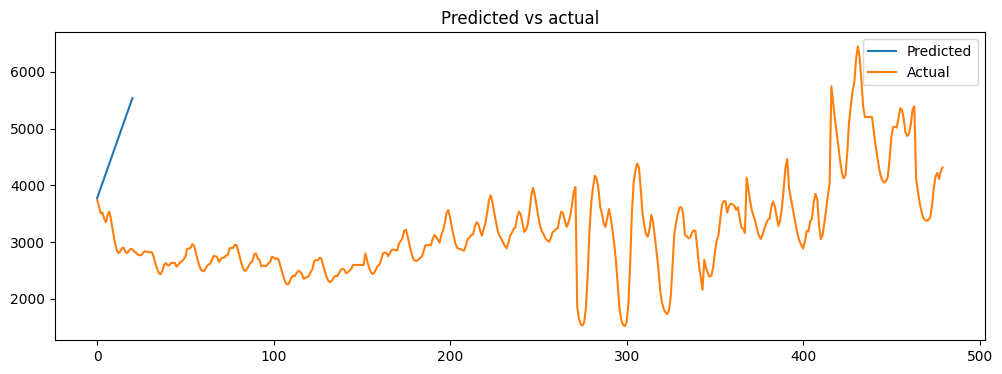

In [150]:
plt.figure(figsize=(12, 4))
plt.plot(X_gen_space.index, X_gen_space['Power demand'], label="Predicted")
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.title('Predicted vs actual')
plt.legend()
plt.show()

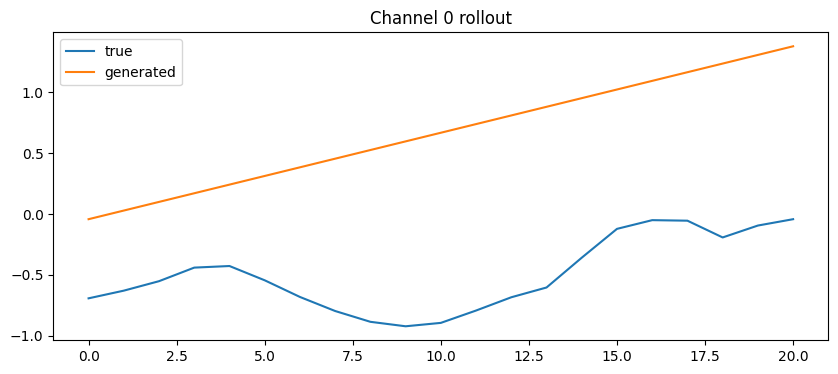

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(X_test_nv[-21:, 0], label="true")
plt.plot(X_gen[:, 0], label="generated")
plt.title("Channel 0 rollout")
plt.legend()
plt.show()